In [64]:
import asyncio
import sqlite3

import requests
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.conditions import TextMentionTermination, MaxMessageTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_openai import ChatOpenAI
from typing import List, Sequence

from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.messages import BaseAgentEvent, BaseChatMessage

from autogen_agentchat.messages import TextMessage
from autogen_agentchat.messages import (
    TextMessage,
    ToolCallRequestEvent,
    FunctionCall,
    RequestUsage,
    ToolCallExecutionEvent,
    FunctionExecutionResult,
    ToolCallSummaryMessage,
    UserInputRequestedEvent,
)


In [65]:
from autogen_agentchat.base import TaskResult



async def stream_db_conversation(stream_result):
    """
    Generator function to stream database conversation messages
    
    Args:
        stream_result: The async generator from db_team.run_stream()
        
    Yields:
        Formatted message strings for each step of the conversation
    """

    
    async for message in stream_result:
        if isinstance(message, TextMessage):
            yield f"💬 {message.source}: {message.content}"
            yield "-" * 40
        elif isinstance(message, ToolCallRequestEvent):
            for tool_call in message.content:
                yield f"🔧 {message.source} calling tool: {tool_call.name}"
                yield f"   Arguments: {tool_call.arguments}"
            yield "-" * 40
        elif isinstance(message, ToolCallExecutionEvent):
            for result_item in message.content:
                yield f"✅ Tool '{result_item.name}' executed"
                if result_item.content:
                    content_preview = result_item.content[:100] + "..." if len(result_item.content) > 100 else result_item.content
                    yield f"   Result: {content_preview}"
            yield "-" * 40
        else:
            yield f"ℹ️ : {type(message).__name__}"
            yield "-" * 40
    

    yield "CONVERSATION COMPLETED"
    yield message


import pandas as pd
import io
import base64
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from typing import List, Tuple, Optional, Union

def create_bar_chart(
    data: List[List[Union[str, int, float]]], 
    title: str = "Bar Chart", 
    color: str = 'skyblue', 
    xlabel: str = "Category", 
    ylabel: str = "Value"
) -> Union[dict]:
    """
    Create a bar chart from list data
    
    Args:
        data: List of [category, value] pairs, e.g., [['A', 23], ['B', 45], ['C', 56]]
              This parameter is required and cannot be None or empty
        title: Title for the chart (default: "Bar Chart")
        color: Bar color (default: 'skyblue')
        xlabel: X-axis label (default: "Category")
        ylabel: Y-axis label (default: "Value")
    
    Returns:
        dict with plot path or error dict with 'error' key
    """
    try:
        if not data:
            return {"error": "Data parameter is required and cannot be empty. Expected format: [['category1', value1], ['category2', value2], ...]"}
        
        if not isinstance(data, list):
            return {"error": "Data must be a list of lists. Expected format: [['category1', value1], ['category2', value2], ...]"}
        
        for i, item in enumerate(data):
            if not isinstance(item, list) or len(item) != 2:
                return {"error": f"Data item at index {i} must be a list with exactly 2 elements [category, value]"}
        
        categories = [str(item[0]) for item in data]
        values = [float(item[1]) for item in data]
        
        plt.figure(figsize=(10, 6))
        plt.bar(categories, values, color=color)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filepath = f"plots/bar_chart_{timestamp}.png"
        os.makedirs("plots", exist_ok=True)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()
        
        return {
            "status": "success",
            "plot_path": filepath,
            "absolute_path": os.path.abspath(filepath)
        }
    except Exception as e:
        plt.close()
        return {"error": f"Error creating bar chart: {str(e)}"}

def create_line_chart(
    data: List[List[Union[int, float]]], 
    title: str = "Line Chart", 
    color: str = 'blue', 
    xlabel: str = "X", 
    ylabel: str = "Y"
) -> Union[dict]:
    """
    Create a line chart from list data
    
    Args:
        data: List of [x, y] pairs, e.g., [[1, 10], [2, 20], [3, 15]]
              This parameter is required and cannot be None or empty
        title: Title for the chart (default: "Line Chart")
        color: Line color (default: 'blue')
        xlabel: X-axis label (default: "X")
        ylabel: Y-axis label (default: "Y")
    
    Returns:
        dict with plot path or error dict with 'error' key
    """
    try:
        if not data:
            return {"error": "Data parameter is required and cannot be empty. Expected format: [[x1, y1], [x2, y2], ...]"}
        
        if not isinstance(data, list):
            return {"error": "Data must be a list of lists. Expected format: [[x1, y1], [x2, y2], ...]"}
        
        for i, item in enumerate(data):
            if not isinstance(item, list) or len(item) != 2:
                return {"error": f"Data item at index {i} must be a list with exactly 2 numeric elements [x, y]"}
        
        x_values = [float(item[0]) for item in data]
        y_values = [float(item[1]) for item in data]
        
        plt.figure(figsize=(10, 6))
        plt.plot(x_values, y_values, marker='o', color=color, linewidth=2)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filepath = f"plots/line_chart_{timestamp}.png"
        os.makedirs("plots", exist_ok=True)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()
        
        return {
            "status": "success",
            "plot_path": filepath,
            "absolute_path": os.path.abspath(filepath)
        }
    except Exception as e:
        plt.close()
        return {"error": f"Error creating line chart: {str(e)}"}

def create_histogram(
    data: List[Union[int, float]], 
    bins: int = 20, 
    title: str = "Histogram", 
    color: str = 'steelblue', 
    xlabel: str = "Values"
) -> Union[dict]:
    """
    Create a histogram from list data
    
    Args:
        data: List of numeric values, e.g., [1, 2, 3, 4, 5, 2, 3, 1]
              This parameter is required and cannot be None or empty
        bins: Number of bins for histogram (default: 20)
        title: Title for the chart (default: "Histogram")
        color: Bar color (default: 'steelblue')
        xlabel: X-axis label (default: "Values")
    
    Returns:
        dict with plot path or error dict with 'error' key
    """
    try:
        if not data:
            return {"error": "Data parameter is required and cannot be empty. Expected format: [value1, value2, value3, ...]"}
        
        if not isinstance(data, list):
            return {"error": "Data must be a list of numeric values. Expected format: [value1, value2, value3, ...]"}
        
        numeric_data = [float(x) for x in data]
        
        plt.figure(figsize=(10, 6))
        plt.hist(numeric_data, bins=bins, alpha=0.7, edgecolor='black', color=color)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filepath = f"plots/histogram_{timestamp}.png"
        os.makedirs("plots", exist_ok=True)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()
        
        return {
            "status": "success",
            "plot_path": filepath,
            "absolute_path": os.path.abspath(filepath)
        }
    except Exception as e:
        plt.close()
        return {"error": f"Error creating histogram: {str(e)}"}

def create_scatter_plot(
    data: List[List[Union[int, float]]], 
    title: str = "Scatter Plot", 
    color: str = 'red', 
    xlabel: str = "X", 
    ylabel: str = "Y"
) -> Union[dict]:
    """
    Create a scatter plot from list data
    
    Args:
        data: List of [x, y] pairs, e.g., [[1, 2], [3, 4], [5, 6]]
              This parameter is required and cannot be None or empty
        title: Title for the chart (default: "Scatter Plot")
        color: Point color (default: 'red')
        xlabel: X-axis label (default: "X")
        ylabel: Y-axis label (default: "Y")
    
    Returns:
        dict with plot path or error dict with 'error' key
    """
    try:
        if not data:
            return {"error": "Data parameter is required and cannot be empty. Expected format: [[x1, y1], [x2, y2], ...]"}
        
        if not isinstance(data, list):
            return {"error": "Data must be a list of lists. Expected format: [[x1, y1], [x2, y2], ...]"}
        
        for i, item in enumerate(data):
            if not isinstance(item, list) or len(item) != 2:
                return {"error": f"Data item at index {i} must be a list with exactly 2 numeric elements [x, y]"}
        
        x_values = [float(item[0]) for item in data]
        y_values = [float(item[1]) for item in data]
        
        plt.figure(figsize=(10, 6))
        plt.scatter(x_values, y_values, alpha=0.7, color=color, s=50)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filepath = f"plots/scatter_plot_{timestamp}.png"
        os.makedirs("plots", exist_ok=True)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()
        
        return {
            "status": "success",
            "plot_path": filepath,
            "absolute_path": os.path.abspath(filepath)
        }
    except Exception as e:
        plt.close()
        return {"error": f"Error creating scatter plot: {str(e)}"}

def create_pie_chart(
    data: List[List[Union[str, int, float]]], 
    title: str = "Pie Chart", 
    colors: Optional[List[str]] = None
) -> Union[dict]:
    """
    Create a pie chart from list data
    
    Args:
        data: List of [label, value] pairs, e.g., [['A', 25], ['B', 35], ['C', 20]]
              This parameter is required and cannot be None or empty
        title: Title for the chart (default: "Pie Chart")
        colors: List of colors for slices (default: None for automatic colors)
    
    Returns:
        dict with plot path or error dict with 'error' key
    """
    try:
        if not data:
            return {"error": "Data parameter is required and cannot be empty. Expected format: [['label1', value1], ['label2', value2], ...]"}
        
        if not isinstance(data, list):
            return {"error": "Data must be a list of lists. Expected format: [['label1', value1], ['label2', value2], ...]"}
        
        for i, item in enumerate(data):
            if not isinstance(item, list) or len(item) != 2:
                return {"error": f"Data item at index {i} must be a list with exactly 2 elements [label, value]"}
        
        labels = [str(item[0]) for item in data]
        values = [float(item[1]) for item in data]
        
        plt.figure(figsize=(8, 8))
        plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis('equal')
        plt.tight_layout()
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filepath = f"plots/pie_chart_{timestamp}.png"
        os.makedirs("plots", exist_ok=True)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()
        
        return {
            "status": "success",
            "plot_path": filepath,
            "absolute_path": os.path.abspath(filepath)
        }
    except Exception as e:
        plt.close()
        return {"error": f"Error creating pie chart: {str(e)}"}



# # Usage example:
# stream_result = db_team.run_stream(task="give me list of item nama and price")
# async for line in stream_db_conversation(stream_result):
#     print(line)


In [66]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI

llm= ChatOpenAI(
    model="gpt-4.1-mini-2025-04-14",
    api_key=api_key,
)


In [67]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities.sql_database import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///ecommerce.db")

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

In [69]:


# Create the LangChain tool adapter for every tool in the toolkit.
db_tools = [LangChainToolAdapter(tool) for tool in toolkit.get_tools()]

# Create the chat completion client.
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")

# Create the assistant agent.
DB_agent = AssistantAgent(
    "Database_enginer",
    model_client=model_client,
    tools=db_tools,  # type: ignore
    system_message="Your task is convert the user query into SQL query and return Data, Respond with 'TERMINATE' if the task is completed",
    description="This agent handles database queries and data retrieval and convert the text into sql which have access to Database"
)


In [70]:
db_team = RoundRobinGroupChat(
    
    [DB_agent],
    termination_condition = TextMentionTermination("TERMINATE") or MaxMessageTermination(10),
)

In [71]:
task1="give me list of item nama and price"
stream_result = db_team.run_stream(task=task1)
async for line in stream_db_conversation(stream_result):
    print(line)


💬 user: give me list of item nama and price
----------------------------------------
🔧 Database_enginer calling tool: sql_db_list_tables
   Arguments: {}
----------------------------------------
✅ Tool 'sql_db_list_tables' executed
   Result: customers, order_items, orders, products, suppliers
----------------------------------------
ℹ️ : ToolCallSummaryMessage
----------------------------------------
🔧 Database_enginer calling tool: sql_db_schema
   Arguments: {"table_names":"products"}
----------------------------------------
✅ Tool 'sql_db_schema' executed
   Result: 
CREATE TABLE products (
	product_id INTEGER, 
	product_name TEXT NOT NULL, 
	category TEXT, 
	price...
----------------------------------------
ℹ️ : ToolCallSummaryMessage
----------------------------------------
🔧 Database_enginer calling tool: sql_db_query
   Arguments: {"query":"SELECT product_name, price FROM products;"}
----------------------------------------
✅ Tool 'sql_db_query' executed
   Result: [('Laptop', 

In [50]:
human_messags="give me list of item nama and profit of each items"
stream_result = db_team.run_stream(task=human_messags)
async for line in stream_db_conversation(stream_result):
    print(line)


💬 user: give me list of item nama and profit of each items
----------------------------------------
🔧 Database_enginer calling tool: sql_db_schema
   Arguments: {"table_names":"order_items"}
----------------------------------------
✅ Tool 'sql_db_schema' executed
   Result: 
CREATE TABLE order_items (
	item_id INTEGER, 
	order_id INTEGER, 
	product_id INTEGER, 
	quantity I...
----------------------------------------
ℹ️ : ToolCallSummaryMessage
----------------------------------------
🔧 Database_enginer calling tool: sql_db_query
   Arguments: {"query":"SELECT p.product_name, (oi.unit_price * oi.quantity) - oi.discount AS profit\nFROM order_items oi\nJOIN products p ON oi.product_id = p.product_id;"}
----------------------------------------
✅ Tool 'sql_db_query' executed
   Result: [('Laptop', 999.99), ('Wireless Mouse', 244.95000000000002), ('Smartphone', 699.99), ('Organic Coffe...
----------------------------------------
ℹ️ : ToolCallSummaryMessage
-----------------------------------

In [51]:
result=line.messages[-1].content.replace("TERMINATE", "")

result

'Here is the list of item names and the profit for each item:\n\n| Product Name         | Profit   |\n|----------------------|----------|\n| Laptop               | 999.99   |\n| Wireless Mouse       | 244.95   |\n| Smartphone           | 699.99   |\n| Organic Coffee       | 24.99    |\n| Headphones           | 199.99   |\n| Coffee Maker         | 149.99   |\n| Organic Coffee       | 24.99    |\n| Wireless Mouse       | 49.99    |\n| Protein Bars         | 19.99    |\n| Tablet               | 489.99   |\n| Smart Watch          | 299.99   |\n| Smart Watch          | 284.99   |\n| Wireless Mouse       | 49.99    |\n| Blender              | 89.99    |\n| Yoga Mat             | 39.99    |\n| Gaming Chair         | 249.99   |\n| Smart Watch          | 299.99   |\n| Yoga Mat             | 39.99    |\n| Blender              | 89.99    |\n| Smart Watch          | 299.99   |\n| Tablet               | 489.99   |\n| Headphones           | 199.99   |\n\nNote: The profits are based on the calculatio

In [ ]:
# # Demo data for testing the 5 chart functions
# demo_bar_data = [['Product A', 100], ['Product B', 150], ['Product C', 75], ['Product D', 200]]
# demo_line_data = [[1, 10], [2, 15], [3, 8], [4, 20], [5, 12]]
# demo_histogram_data = [1, 2, 2, 3, 3, 3, 4, 4, 5, 1, 2, 3, 4, 5, 3, 2, 1]
# demo_scatter_data = [[1, 5], [2, 8], [3, 12], [4, 7], [5, 15]]
# demo_pie_data = [['Category A', 30], ['Category B', 45], ['Category C', 25]]

# print("Testing create_bar_chart:")
# result1 = create_bar_chart(demo_bar_data, title="Demo Bar Chart", color="blue")
# print(result1)

# print("\nTesting create_line_chart:")
# result2 = create_line_chart(demo_line_data, title="Demo Line Chart", color="green")
# print(result2)

# print("\nTesting create_histogram:")
# result3 = create_histogram(demo_histogram_data, title="Demo Histogram", color="orange")
# print(result3)

# print("\nTesting create_scatter_plot:")
# result4 = create_scatter_plot(demo_scatter_data, title="Demo Scatter Plot", color="purple")
# print(result4)

# print("\nTesting create_pie_chart:")
# result5 = create_pie_chart(demo_pie_data, title="Demo Pie Chart")
# print(result5)

Testing create_bar_chart:
{'status': 'success', 'plot_path': 'plots/bar_chart_20250617_161618.png', 'absolute_path': 'd:\\AutoInsight-AI\\notebook\\plots\\bar_chart_20250617_161618.png'}

Testing create_line_chart:
{'status': 'success', 'plot_path': 'plots/line_chart_20250617_161619.png', 'absolute_path': 'd:\\AutoInsight-AI\\notebook\\plots\\line_chart_20250617_161619.png'}

Testing create_histogram:
{'status': 'success', 'plot_path': 'plots/histogram_20250617_161620.png', 'absolute_path': 'd:\\AutoInsight-AI\\notebook\\plots\\histogram_20250617_161620.png'}

Testing create_scatter_plot:
{'status': 'success', 'plot_path': 'plots/scatter_plot_20250617_161620.png', 'absolute_path': 'd:\\AutoInsight-AI\\notebook\\plots\\scatter_plot_20250617_161620.png'}

Testing create_pie_chart:
{'status': 'success', 'plot_path': 'plots/pie_chart_20250617_161621.png', 'absolute_path': 'd:\\AutoInsight-AI\\notebook\\plots\\pie_chart_20250617_161621.png'}


In [62]:
tools=[create_line_chart , create_pie_chart , create_scatter_plot, create_histogram, create_bar_chart]
# Create the chat completion client.
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")

# Create the assistant agent.
Data_visualization = AssistantAgent(
    "Data_visualization",
    model_client=model_client,
    tools=tools,  # type: ignore
    system_message="You are a data visualization expert. Analyze the provided data and create the most suitable chart using one of these functions: create_line_chart, create_pie_chart, create_scatter_plot, create_histogram, or create_bar_chart. Choose the chart type that best represents the data patterns and relationships. After successfully creating the plot, respond with 'TERMINATE' to indicate task completion.",
    reflect_on_tool_use=False,
    description="This agent create the data visulization based given data"
)




In [92]:
visualization = RoundRobinGroupChat(
    
    [Data_visualization],
    termination_condition=TextMentionTermination("TERMINATE") or MaxMessageTermination(10)
)
stream_result = visualization.run_stream(task=f"create the graph for given data   {result}, i want in red color ")
async for line in stream_db_conversation(stream_result):
    print(line)
    

💬 user: create the graph for given data   Here is the list of item names and the profit for each item:

| Product Name         | Profit   |
|----------------------|----------|
| Laptop               | 999.99   |
| Wireless Mouse       | 244.95   |
| Smartphone           | 699.99   |
| Organic Coffee       | 24.99    |
| Headphones           | 199.99   |
| Coffee Maker         | 149.99   |
| Organic Coffee       | 24.99    |
| Wireless Mouse       | 49.99    |
| Protein Bars         | 19.99    |
| Tablet               | 489.99   |
| Smart Watch          | 299.99   |
| Smart Watch          | 284.99   |
| Wireless Mouse       | 49.99    |
| Blender              | 89.99    |
| Yoga Mat             | 39.99    |
| Gaming Chair         | 249.99   |
| Smart Watch          | 299.99   |
| Yoga Mat             | 39.99    |
| Blender              | 89.99    |
| Smart Watch          | 299.99   |
| Tablet               | 489.99   |
| Headphones           | 199.99   |

Note: The profits are based on 

{'status': 'success', 'plot_path': 'plots/bar_chart_20250617_162915.png', 'absolute_path': 'd:\\AutoInsight-AI\\notebook\\plots\\bar_chart_20250617_162915.png'}
plots/bar_chart_20250617_162915.png


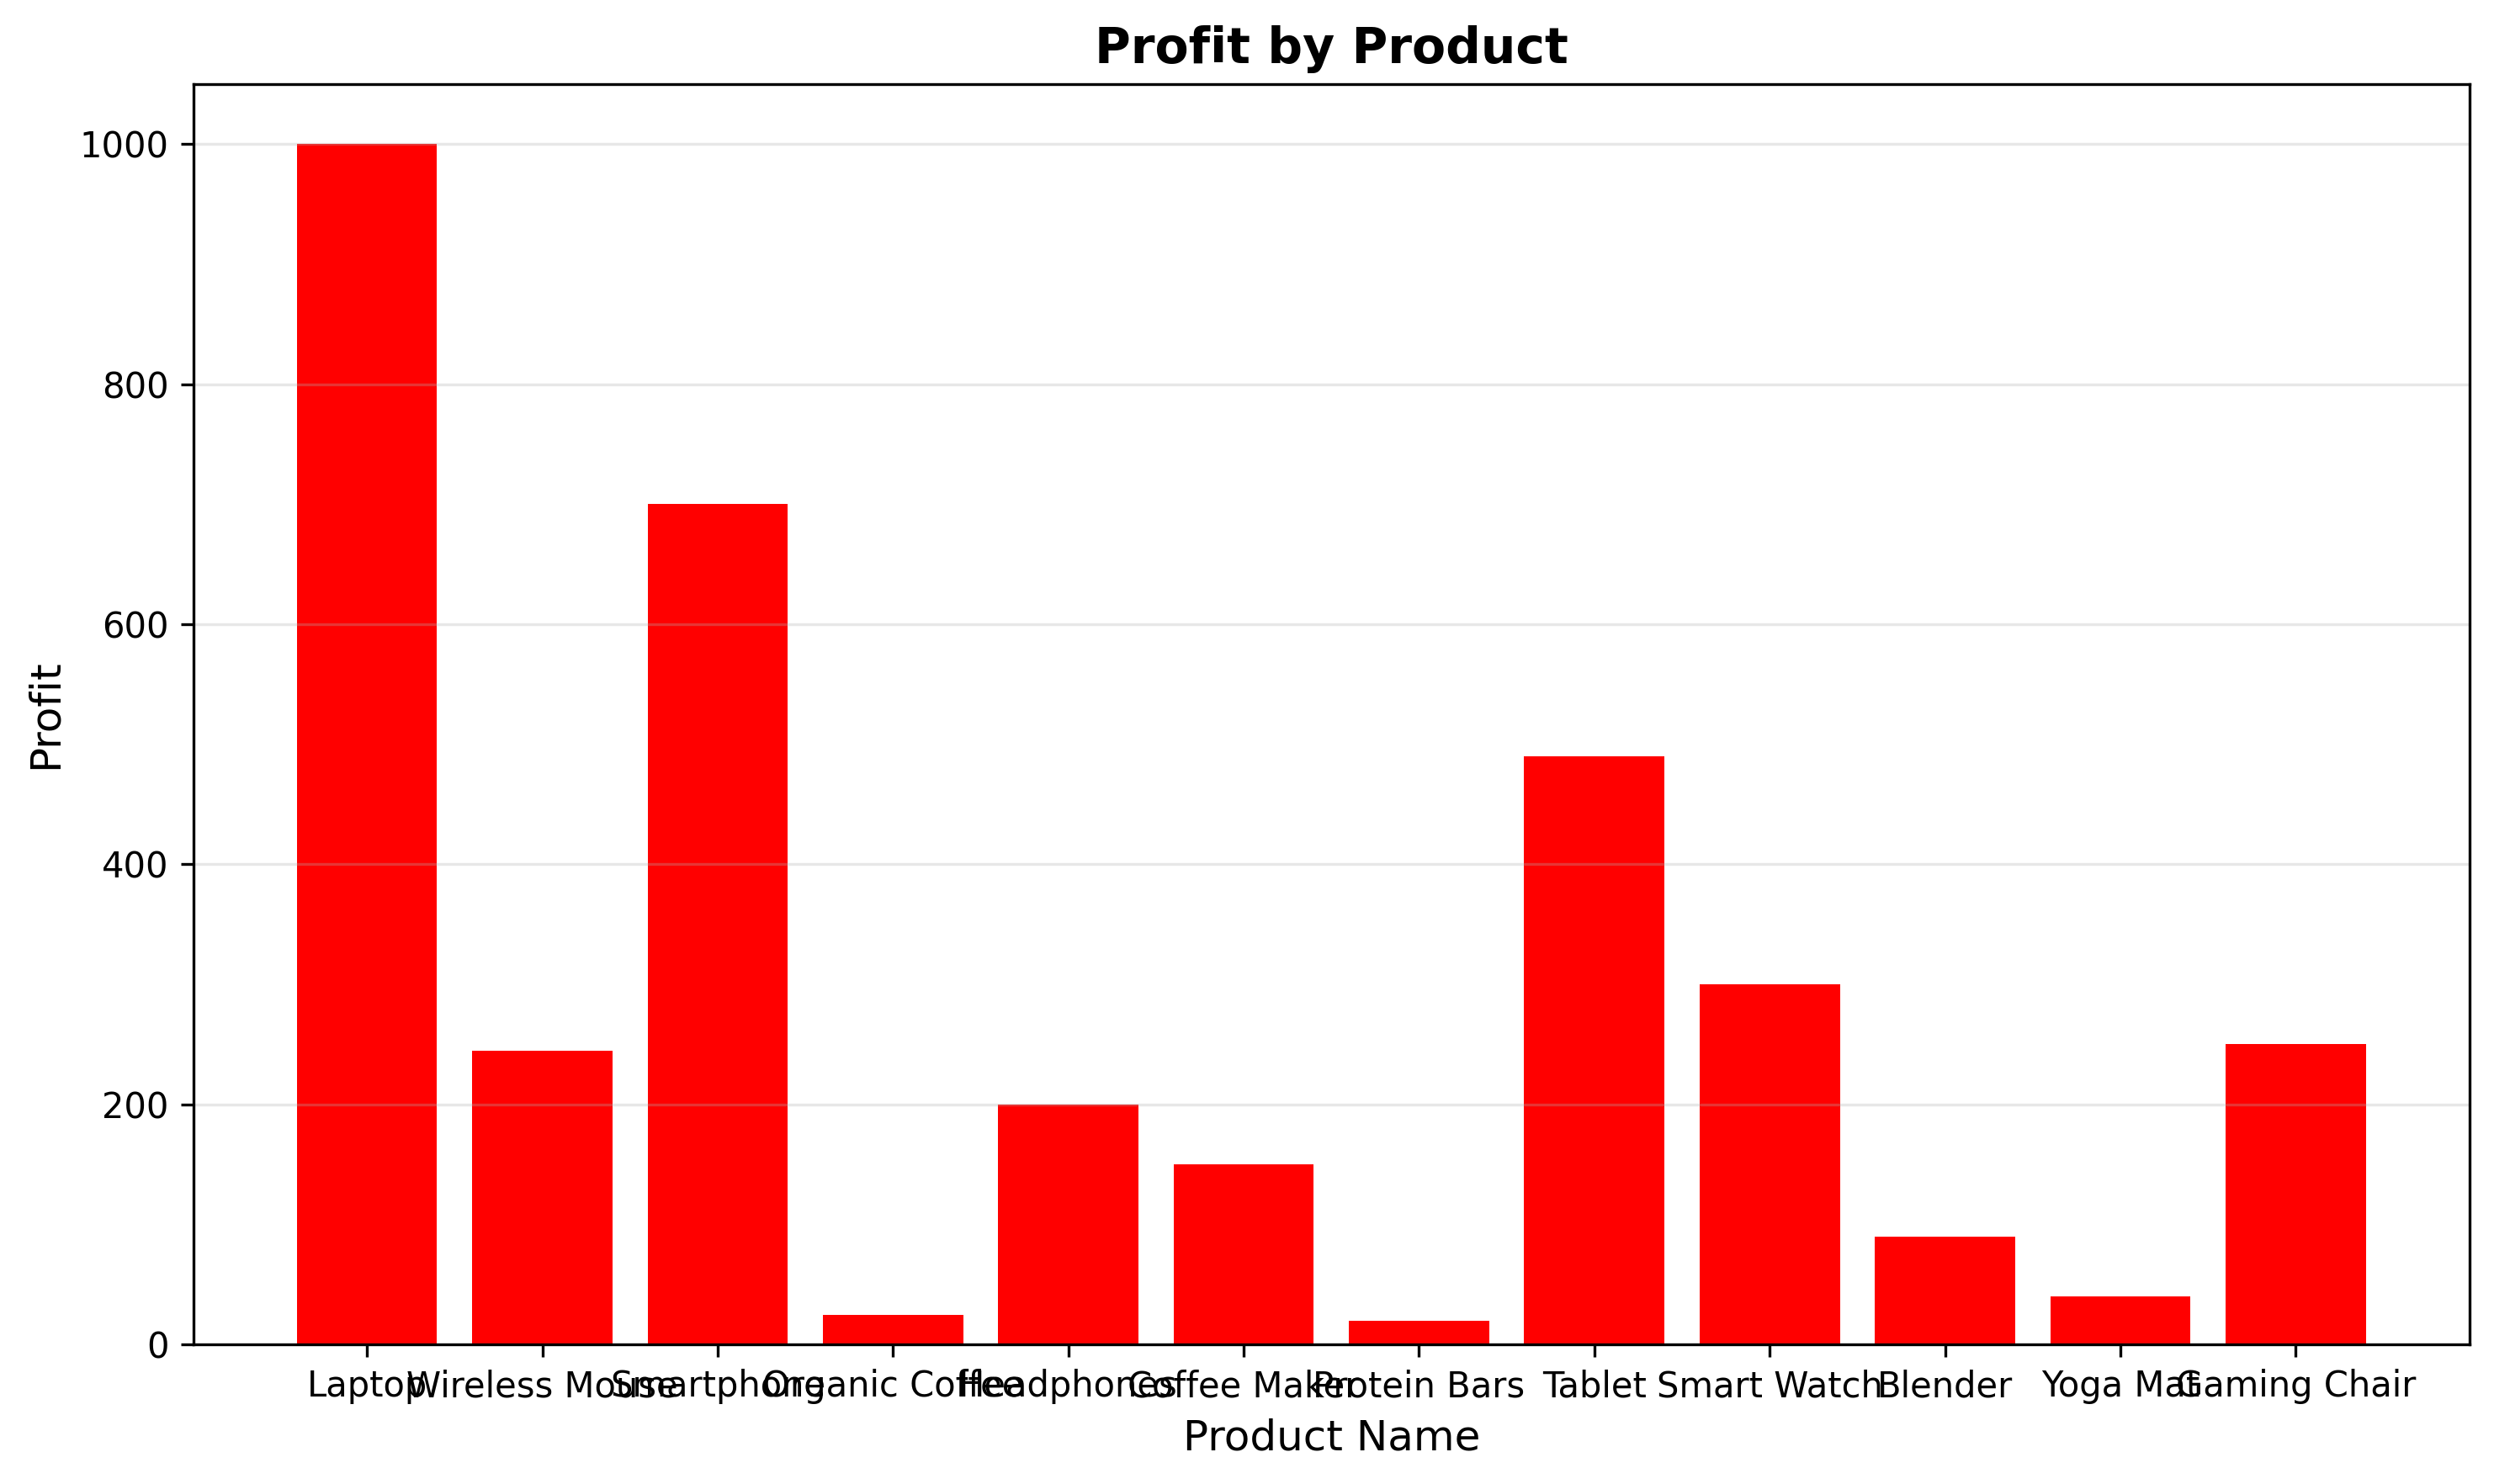

In [93]:
import json
from IPython.display import Image, display

for message in line.messages:
    if isinstance(message, ToolCallExecutionEvent):
        content_str = message.content[-1].content
        print(content_str)
        # Convert the string representation of dictionary to actual dictionary
        plot_result = json.loads(content_str.replace("'", '"'))  # Use json.loads instead of eval
        print(plot_result['plot_path'])
        
        # Display the image
        display(Image(filename=plot_result['plot_path']))

In [73]:
human_messags="i want in deep pink color  graph for given data   {result}, "
stream_result = visualization.run_stream(task=human_messags)
async for line in stream_db_conversation(stream_result):
    print(line)

💬 user: i want in deep pink color  graph for given data   {result}, 
----------------------------------------
🔧 Data_visualization calling tool: create_bar_chart
   Arguments: {"data":[["Laptop",999.99],["Wireless Mouse",244.95],["Smartphone",699.99],["Organic Coffee",24.99],["Headphones",199.99],["Coffee Maker",149.99],["Wireless Mouse",49.99],["Protein Bars",19.99],["Tablet",489.99],["Smart Watch",299.99],["Smart Watch",284.99],["Wireless Mouse",49.99],["Blender",89.99],["Yoga Mat",39.99],["Gaming Chair",249.99],["Smart Watch",299.99],["Yoga Mat",39.99],["Blender",89.99],["Smart Watch",299.99],["Tablet",489.99],["Headphones",199.99]],"title":"Profit by Product","color":"deeppink","xlabel":"Product Name","ylabel":"Profit"}
----------------------------------------
✅ Tool 'create_bar_chart' executed
   Result: {'status': 'success', 'plot_path': 'plots/bar_chart_20250617_162040.png', 'absolute_path': 'd:\\Auto...
----------------------------------------
ℹ️ : ToolCallSummaryMessage
------

{'status': 'success', 'plot_path': 'plots/bar_chart_20250617_162040.png', 'absolute_path': 'd:\\AutoInsight-AI\\notebook\\plots\\bar_chart_20250617_162040.png'}
plots/bar_chart_20250617_162040.png


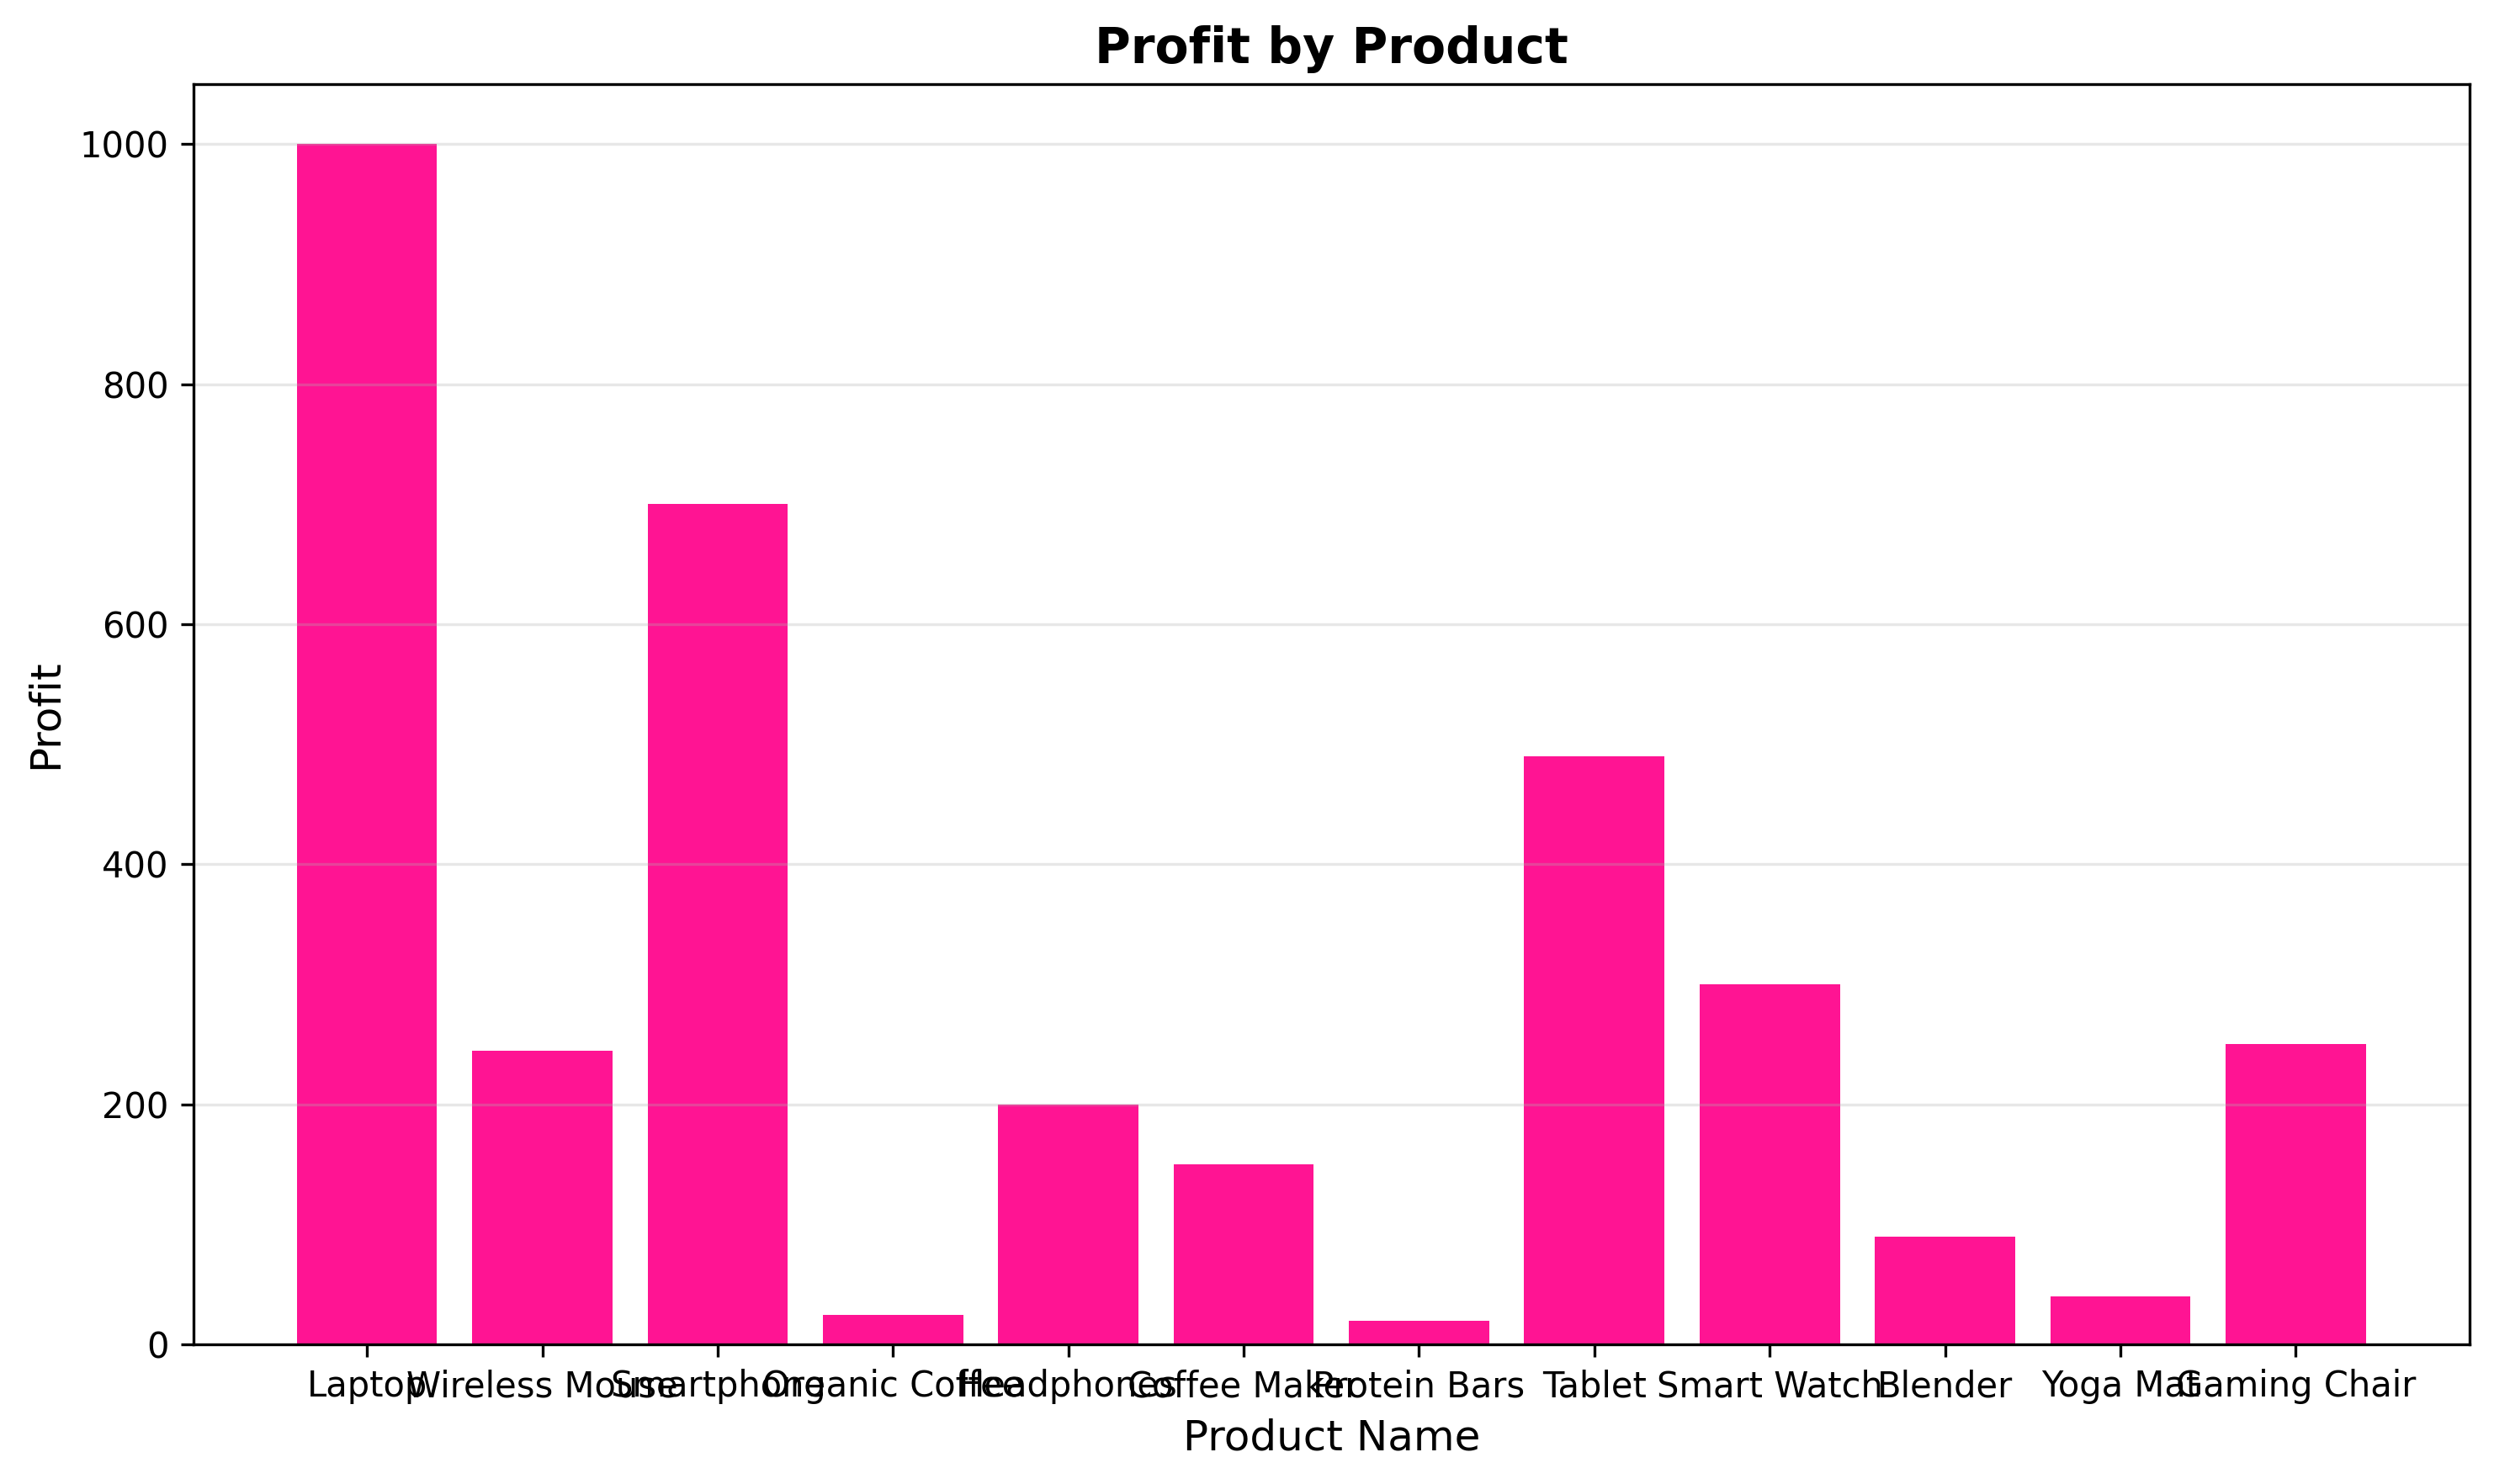

In [91]:
import json
from IPython.display import Image, display

for message in line.messages:
    if isinstance(message, ToolCallExecutionEvent):
        content_str = message.content[-1].content
        print(content_str)
        # Convert the string representation of dictionary to actual dictionary
        plot_result = json.loads(content_str.replace("'", '"'))  # Use json.loads instead of eval
        print(plot_result['plot_path'])
        
        # Display the image
        display(Image(filename=plot_result['plot_path']))


In [ ]:
await db_team.reset()



await visualization.reset()